In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 21.3MB/s 
     |████████████████████████████████| 1.1MB 51.6MB/s 
     |████████████████████████████████| 890kB 56.3MB/s 
     |████████████████████████████████| 2.9MB 55.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a7b136354f1ed8d88e94259da1165d9e2a8f560da481a2b9edda2c505a496b51
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
def read_data(filename):
    file_content = pd.read_excel(filename)
    return file_content

In [ ]:
# using split data
train_data = read_data('train_data_offensive_language_marathi_updated.xlsx')
test_data = read_data('test_data_offensive_language_marathi_updated.xlsx')

X_train, X_valid, Y_train, Y_valid = train_data.Tweet, test_data.Tweet, train_data.Class, test_data.Class

In [ ]:
tokenizer = Tokenizer(nb_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(train_data['Tweet'].values)
# print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(train_data['Tweet'].values)
X = pad_sequences(X)

Y = pd.get_dummies(train_data['Class']).values

X_valid = tokenizer.texts_to_sequences(test_data['Tweet'].values)
X_valid = pad_sequences(X_valid)
Y_valid = pd.get_dummies(test_data['Class']).values

In [ ]:
embed_dim = 128
lstm_out = 256
batch_size = 16

model = Sequential()
model.add(Embedding(3000, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

#Here we train the Network.

model.fit(X, Y, batch_size =batch_size, verbose = 5)
score, acc = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 128)           384000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 778,754
Trainable params: 778,754
Non-trainable params: 0
_________________________________________________________________
None
40/40 - 0s - loss: 0.3899 - accuracy: 0.8592


In [ ]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        print("recall====", recall)
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        print("precision= ", precision)
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    print("F1 score",2*((precision*recall)/(precision+recall+K.epsilon())))
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

In [ ]:
model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=METRICS)
model.fit(X, Y, batch_size =batch_size, verbose = 5)
# score, acc = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size=batch_size)

In [ ]:
prediction = model.predict(X_valid)
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0     0.8708    0.9354    0.9020       418
           1     0.8466    0.7198    0.7781       207

   micro avg     0.8640    0.8640    0.8640       625
   macro avg     0.8587    0.8276    0.8400       625
weighted avg     0.8628    0.8640    0.8609       625
 samples avg     0.8640    0.8640    0.8640       625

86.4


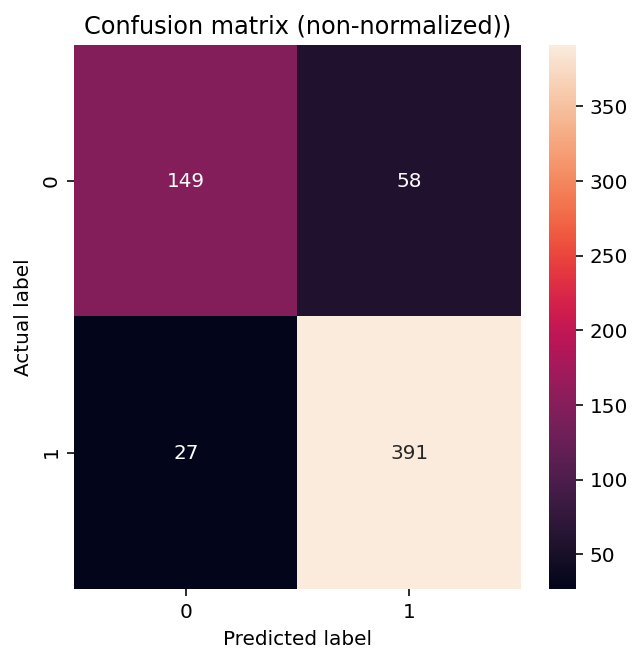

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(Y_valid, y_pred, digits=4)
print(report)

def plot_cm(labels, predictions, p=0.5):
    # print(labels)
    # print(predictions)
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

newLabels = []
for val in Y_valid:
  if val[0] == True and val[1] == False:
    newLabels.append(1)
  else:
    newLabels.append(0)

newPred = []
for val in y_pred:
  if val[0] == True and val[1] == False:
    newPred.append(1)
  else:
    newPred.append(0)
print(metrics.accuracy_score(newLabels, newPred)*100)
plot_cm(newLabels, newPred)